In [40]:
quit()

In [3]:
import pykat
from pykat import finesse
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.patches as patches
from prettytable import PrettyTable
import utils_DRFPMI as utl
    
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

c = 299792458
pi = np.pi

                                              ..-
    PyKat 1.2.81          _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



# Somiya Model
## - PRFPMI
## - No schnupp assymetry
## - Additional path from REFL to REFL_WFS

In [4]:
# PRC length
l_short_MI = (26.4018+23.072)/2

print(c/2/45.0159e+6*20)
#
# c/2/L = FSR
# L = c/2/FSR
#
print(l_short_MI)

66.59701527682441
24.7369


In [13]:
WFSbase = utl.model_HOM_DRFPMI()
WFSbase.verbose=True

# Input power
WFSbase.i1.P = 83.74

# PRFPMI
WFSbase.SRM.R = 0
WFSbase.SRM.T = 1
WFSbase.SRM.L = 0

# No schnupp assymetry
WFSbase.lx.L = l_short_MI
WFSbase.ly.L = l_short_MI

# Adjusting mirror parameters
WFSbase.ETMX.R = 0.999945
WFSbase.ETMX.T = 10e-6
WFSbase.ETMX.L = 45e-6
WFSbase.ETMY.R = 0.999945
WFSbase.ETMY.T = 10e-6
WFSbase.ETMY.L = 45e-6

WFSbase.ITMX.R = 0.996
WFSbase.ITMX.T = 0.004
WFSbase.ITMX.L = 0
WFSbase.ITMY.R = 0.996
WFSbase.ITMY.T = 0.004
WFSbase.ITMY.L = 0


# Adding a pick off at REFL
# s s_eo2 0 n_eo4 nREFL
WFSbase.s_eo2.remove()

#kat.add(mirror("m3", "n2a", "n3a", R=0.9, T=0.1, phi=0))
#kat.add(space("s2", "n2", "n2a", L=1))
#kat.add(space("s3", "n3", "n3a", L=1))
# bs1 name T Loss phi alpha node1 node2 node3 node4
# bs2 name R Loss phi alpha node1 node2 node3 node4

WFSbase.parse("""
s s_eo2 0 n_eo4 n_eo5
bs2 bs_refl_po 0.0001 0 0 45 n_eo5 dump n_refl_east n_refl_south
s s_eo3 0 n_refl_east nREFL
s s_refl_wfs 0 n_refl_south n_refl_wfs
""")



In [14]:
print(WFSbase.i1.P)

83.74


## Changing R_PRM

--------------------------------------------------------------
Running kat - Started at 2021-09-06 02:13:41.185156
Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.154209 seconds
PRM R = 0.3
--------------------------------------------------------------
Running kat - Started at 2021-09-06 02:13:41.341380


 91% | ETA:  0:00:00 | Calculating                                             

100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.143222 seconds
PRM R = 0.6
--------------------------------------------------------------
Running kat - Started at 2021-09-06 02:13:41.486656
Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.144693 seconds
PRM R = 0.9
--------------------------------------------------------------
Running kat - Started at 2021-09-06 02:13:41.633354
Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.148276 seconds
PRM R = 0.95
PRFPMI, 0.95, YAW, at REFL (maxtem1, gouy 0)


100% | ETA:  0:00:00 | Calculating                                             

<bound method Figure.show of <Figure size 720x720 with 2 Axes>>

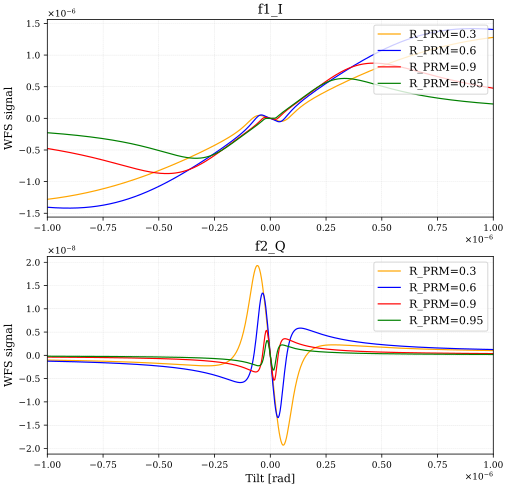

In [9]:
model = WFSbase.deepcopy( )

model.parse("""
const fsb1 16.881M
const fsb2 45.0159M

pd1 WFS1_P_I $fsb1 0 n_refl_wfs
pd1 WFS1_P_Q $fsb1 90 n_refl_wfs
pd1 WFS1_P_M $fsb1 max n_refl_wfs

pd1 WFS2_P_I $fsb2 0 n_refl_wfs
pd1 WFS2_P_Q $fsb2 90 n_refl_wfs
pd1 WFS2_P_M $fsb2 max n_refl_wfs

pdtype WFS1_P_I x-split
pdtype WFS1_P_Q x-split
pdtype WFS1_P_M x-split

pdtype WFS2_P_I x-split
pdtype WFS2_P_Q x-split
pdtype WFS2_P_M x-split

attr s_refl_wfs g 0

maxtem 1

xaxis ETMX xbeta lin -1u 1u 500

""")

#print("".join(model.generateKatScript()))


#ETMX-ITMX-ETMY-ITMY
#### WFS REFL #####
# 0-0-180-180: CH #
# 0- 0- 0- 0 : DH #
# 0-180-180-0: CS #
# 0-180-0-180: DS #
###################

motion = ['CH']
dof = 'YAW'
R_PRM = [0.3, 0.6, 0.9, 0.95]
col = ['orange','blue','red','green']

fig, ax = plt.subplots(2,figsize=(8,8))
    
for x in range(0,4):

    model.PRM.R = R_PRM[x]
    model.PRM.T = 1 - model.PRM.L - model.PRM.R

    model.parse("""
    put* ITMX xbeta $x1
    put* ETMY xbeta $mx1       
    put* ITMY xbeta $mx1
    """)
    output = model.run()
    
    print('PRM R = '+str(model.PRM.R))
    ax[0].plot(output.x, output["WFS1_P_I"], label="R_PRM="+str(model.PRM.R), color=col[x])
    #ax[0].plot(output.x, output["WFS1_P_Q"], color='orange')

    ax[1].plot(output.x, output["WFS2_P_I"], label="R_PRM="+str(model.PRM.R), color=col[x])
    #ax[1].plot(output.x, output["WFS2_P_Q"], color='orange')

    ax[1].set_xlabel('Tilt [rad]')
    ax[0].set_ylabel('WFS signal')
    ax[1].set_ylabel('WFS signal')

title = 'PRFPMI, ' + str(model.PRM.R) + ', ' + dof + ', at REFL (maxtem1, gouy 0)'
f = './figures/PRFPMI_' + str(model.PRM.R) + '_' + dof + '_REFL_zoom'
print(title)
ax[0].set_title('f1_I')
ax[1].set_title('f2_Q')

ax[0].legend(loc=1)
ax[1].legend(loc=1)
#plt.savefig(f,dpi=300)
fig.show




## Changing DoF

CH
--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:15:14.074789


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.265133 seconds
PRFPMI, CH, YAW, at REFL (maxtem1, gouy 94)


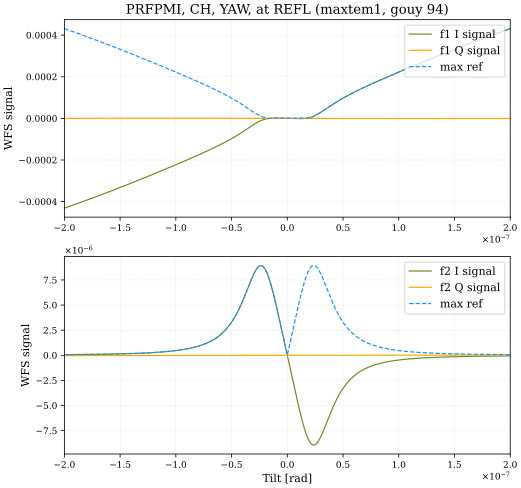

In [42]:
model = WFSbase.deepcopy( )

model.parse("""
const fsb1 16.881M
const fsb2 45.0159M

pd1 WFS1_P_I $fsb1 0 n_refl_wfs
pd1 WFS1_P_Q $fsb1 90 n_refl_wfs
pd1 WFS1_P_M $fsb1 max n_refl_wfs

pd1 WFS2_P_I $fsb2 0 n_refl_wfs
pd1 WFS2_P_Q $fsb2 90 n_refl_wfs
pd1 WFS2_P_M $fsb2 max n_refl_wfs

pdtype WFS1_P_I x-split
pdtype WFS1_P_Q x-split
pdtype WFS1_P_M x-split

pdtype WFS2_P_I x-split
pdtype WFS2_P_Q x-split
pdtype WFS2_P_M x-split

maxtem 1

xaxis ETMX xbeta lin -0.2u 0.2u 1000

""")

motion = ['CH','DH','CS','DS']
motion = ['CH']
dof = 'YAW'
gouy = 94

for x in motion:

    if x == 'CH':
        print(x)
        model.parse("""
        put* ITMX xbeta $x1
        put* ETMY xbeta $mx1
        put* ITMY xbeta $mx1
        """)
        model.s_refl_wfs.gx = gouy
        model.s_refl_wfs.gy = gouy


    elif x == 'DH':
        print(x)
        model.parse("""
        put* ITMX xbeta $x1
        put* ETMY xbeta $x1
        put* ITMY xbeta $x1
        """)
        model.s_refl_wfs.gx = gouy
        model.s_refl_wfs.gy = gouy

        
    elif x == 'CS':
        print(x)
        model.parse("""
        put* ITMX xbeta $mx1
        put* ETMY xbeta $mx1
        put* ITMY xbeta $x1
        """)
        model.s_refl_wfs.gx = gouy
        model.s_refl_wfs.gy = gouy

    elif x == 'DS':
        print(x)
        model.parse("""
        put* ITMX xbeta $mx1
        put* ETMY xbeta $x1
        put* ITMY xbeta $mx1
        """)
        model.s_refl_wfs.gx = gouy
        model.s_refl_wfs.gy = gouy
        
    output = model.run()

    fig, ax = plt.subplots(2,figsize=(8,8))
    ax[0].plot(output.x, output["WFS1_P_I"], label="f1 I signal", color='olivedrab')
    ax[0].plot(output.x, output["WFS1_P_Q"], label="f1 Q signal", color='orange')
    ax[0].plot(output.x, output["WFS1_P_M"], '--',label="max ref", color='dodgerblue')

    ax[1].plot(output.x, output["WFS2_P_I"], label="f2 I signal", color='olivedrab')
    ax[1].plot(output.x, output["WFS2_P_Q"], label="f2 Q signal", color='orange')
    ax[1].plot(output.x, output["WFS2_P_M"], '--',label="max ref", color='dodgerblue')

    ax[1].set_xlabel('Tilt [rad]')
    ax[0].set_ylabel('WFS signal')
    ax[1].set_ylabel('WFS signal')

    title = 'PRFPMI, ' + x + ', ' + dof + ', at REFL (maxtem1, gouy ' + str(gouy)+')'
    f = './figures/PRFPMI_NoAsym_' + x + '_' + dof + '_REFL_gouy' + str(gouy)
    print(title)
    ax[0].set_title(title)
    ax[0].legend(loc=1)
    ax[1].legend(loc=1)
    plt.savefig(f,dpi=300)
    fig.show




In [63]:
print(model.s_refl_wfs.gx)
print(model.PRM.L)
print(model.PRM.T)
print(model.PRM.R)

0.0
4.5e-05
0.1
None


In [18]:
print("".join(model.generateKatScript()))


% Generated by PyKat 08.09.2021 05:43:16

l i1 83.74 0.0 0.0 n0
s s_eo0 0.0 n0 n_eo1
mod eom1 16881000.0 0.3 1 pm 0.0 n_eo1 n_eo2
s s_eo1 0.0 n_eo2 n_eo3
mod eom2 45015900.0 0.3 1 pm 0.0 n_eo3 n_eo4
m1 PRM 0.1 4.5e-05 90.0 nREFL npr1
attr PRM Rcx -458.1285
attr PRM Rcy -458.1285
s sLpr1 14.7615 npr1 npr2
bs1 PR2 0.0005 4.5e-05 0.0 0.686 npr3 npr2 nPOP nPOP2
attr PR2 Rcx -3.0764
attr PR2 Rcy -3.0764
s sLpr2 11.0661 npr3 npr4
bs1 PR3 5e-05 4.5e-05 0.0 0.686 dump dump npr4 npr5
attr PR3 Rcx -24.9165
attr PR3 Rcy -24.9165
s sLpr3 15.7638 npr5 npr6
bs bs1 0.5 0.5 0.0 45.0 npr6 n2 n3 n4
attr bs1 Rcx 0.0
attr bs1 Rcy 0.0
s lx 24.7369 n3 nx1
s ly 24.7369 n2 ny1
m IXAR 0.0 1.0 0.0 nx1 nx2
attr IXAR Rcx 0.0
attr IXAR Rcy 0.0
s thick_IX 0.15 1.754 nx2 nx3
m ITMX 0.996 0.004 0.0 nx3 nx4
attr ITMX Rcx -1900.0
attr ITMX Rcy -1900.0
m IYAR 0.0 1.0 0.0 ny1 ny2
attr IYAR Rcx 0.0
attr IYAR Rcy 0.0
s thick_IY 0.15 1.754 ny2 ny3
m ITMY 0.996 0.004 90.0 ny3 ny4
attr ITMY Rcx -1900.0
attr ITMY Rcy -1900.0
s

# Field Check

## PRCL

--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:01:05.098078


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.471576 seconds


<function matplotlib.pyplot.show(*args, **kw)>

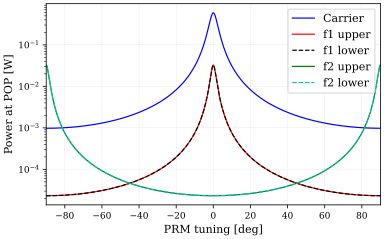

In [31]:
model, out_p = utl.run_sweep('PRCL',WFSbase)

plt.figure(1)
plt.semilogy(out_p.x, out_p["CR_POP"]**2,label="Carrier") # CR => 0
plt.semilogy(out_p.x, out_p["SB1p_POP"]**2,label="f1 upper")
plt.semilogy(out_p.x, out_p["SB1m_POP"]**2,label="f1 lower",LineStyle='--')

plt.semilogy(out_p.x, out_p["SB2p_POP"]**2,label="f2 upper")
plt.semilogy(out_p.x, out_p["SB2m_POP"]**2,label="f2 lower",LineStyle='--')


plt.xlabel("PRM tuning [deg]")
plt.ylabel("Power at POP [W]")
plt.legend(loc=1)
plt.savefig('./figures/sweep_PRCL_POP.png')
plt.show

## MICH

--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:01:08.361689


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.566449 seconds


<function matplotlib.pyplot.show(*args, **kw)>

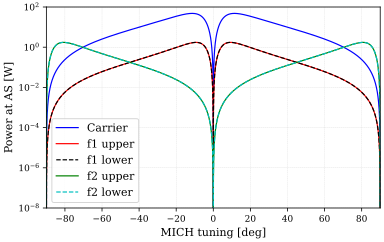

In [32]:
model, out_p = utl.run_sweep('MICH', WFSbase)

plt.figure(1)
plt.semilogy(out_p.x, out_p["CR_AS"]**2,label="Carrier") # CR => 0
plt.semilogy(out_p.x, out_p["SB1p_AS"]**2,label="f1 upper")
plt.semilogy(out_p.x, out_p["SB1m_AS"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out_p.x, out_p["SB2p_AS"]**2,label="f2 upper")
plt.semilogy(out_p.x, out_p["SB2m_AS"]**2,label="f2 lower",LineStyle='--')


plt.xlabel("MICH tuning [deg]")
plt.ylabel("Power at AS [W]")
plt.ylim(1e-8,1e2)
plt.legend(loc=3)
plt.savefig('./figures/sweep_MICH_AS.png')
plt.show

## SRCL

--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:01:11.250779


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.454844 seconds
--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:01:11.706371


100% | ETA:  0:00:00 | Saving data                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.423747 seconds


<function matplotlib.pyplot.show(*args, **kw)>

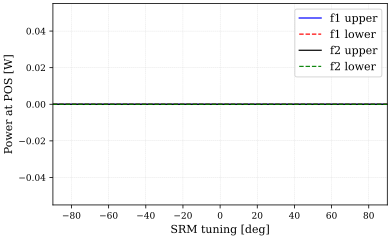

In [33]:
model, out = utl.run_sweep('SRCL', WFSbase)
model.SRM.phi = 0
out = model.run()

plt.figure(1)
#plt.semilogy(out.x, out["CR_POS"]**2,label="Carrier") # CR => 0
plt.plot(out.x, out["SB1p_POS"]**2,label="f1 upper")
plt.plot(out.x, out["SB1m_POS"]**2,label="f1 lower",LineStyle='--')
plt.plot(out.x, out["SB2p_POS"]**2,label="f2 upper")
plt.plot(out.x, out["SB2m_POS"]**2,label="f2 lower",LineStyle='--')
plt.xlabel("SRM tuning [deg]")
plt.ylabel("Power at POS [W]")
plt.savefig('./figures/sweep_SRCL_POS.png')
plt.legend(loc=1)
plt.show

## ARM

--------------------------------------------------------------
Running kat - Started at 2021-09-08 06:02:25.457122


100% | ETA:  0:00:00 | Calculating                                             

Used Finesse 2.3.1 at /Users/keiko/opt/anaconda3/envs/py37/bin/kat

Finished in 0.384415 seconds


<function matplotlib.pyplot.show(*args, **kw)>

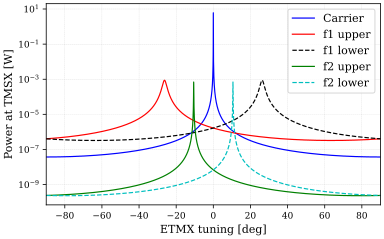

In [35]:
model = WFSbase.deepcopy()
model.parse("""
xaxis ETMX phi lin -90 90 5000
yaxis lin abs""")

out = model.run()

plt.figure(1)
plt.semilogy(out.x, out["CR_TMSX"]**2,label="Carrier") # CR => 0
plt.semilogy(out.x, out["SB1p_TMSX"]**2,label="f1 upper")
plt.semilogy(out.x, out["SB1m_TMSX"]**2,label="f1 lower",LineStyle='--')
plt.semilogy(out.x, out["SB2p_TMSX"]**2,label="f2 upper")
plt.semilogy(out.x, out["SB2m_TMSX"]**2,label="f2 lower",LineStyle='--')

plt.xlabel("ETMX tuning [deg]")
plt.ylabel("Power at TMSX [W]")
#plt.ylim(1e-14,1e-3)
plt.legend(loc=1)
plt.savefig('./figures/sweep_ETMX_TMSX.png')
plt.show
